In [1]:
import torch, torchdata, torchtext
from torch import nn

import time

#1. puffer - it's outdated....
#2. spend some money - 300 baht get collab pro

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.current_device(),torch.cuda.get_device_name(torch.cuda.current_device()))

#reproducibility 
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

c:\Users\ASUS\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0 NVIDIA GeForce RTX 3060 Laptop GPU


In [2]:
print(torch.cuda.is_available())

True


In [3]:
! nvidia-smi

Tue Feb 14 22:35:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.78       Driver Version: 512.78       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   40C    P8    10W /  N/A |      0MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Load dataset

In [4]:
from torchtext.datasets import SST2

# load Stanford Sentiment Treebank v2
train_datapipe = SST2(split="train")

In [5]:
# dataset example
list(iter(train_datapipe))[:10]

[('hide new secretions from the parental units', 0),
 ('contains no wit , only labored gags', 0),
 ('that loves its characters and communicates something rather beautiful about human nature',
  1),
 ('remains utterly satisfied to remain the same throughout', 0),
 ('on the worst revenge-of-the-nerds clichés the filmmakers could dredge up',
  0),
 ("that 's far too tragic to merit such superficial treatment", 0),
 ('demonstrates that the director of such hollywood blockbusters as patriot games can still turn out a small , personal film with an emotional wallop .',
  1),
 ('of saucy', 1),
 ("a depressed fifteen-year-old 's suicidal poetry", 0),
 ("are more deeply thought through than in most ` right-thinking ' films", 1)]

In [6]:
# load val
val = SST2(split="dev")

In [7]:
# split train for test if we want
train, test = train_datapipe.random_split(total_length=len(list(iter(train_datapipe))), weights = {"smaller_train": 0.98, "test": 0.02}, seed=999)

In [8]:
# see number each set
train_size = len(list(iter(train)))
val_size   = len(list(iter(val)))
test_size   = len(list(iter(test)))
train_size, val_size ,test_size

(66002, 872, 1347)

In [9]:
# label
set([x for y, x in list(iter(train_datapipe))])

{0, 1}

## Preprocess

In [10]:
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

In [11]:
from torchtext.vocab import build_vocab_from_iterator

def yield_tokens(data_iter):  #data_iter, e.g., train
    for text,_  in data_iter:
        yield tokenizer(text)
        
vocab = build_vocab_from_iterator(yield_tokens(train_datapipe), specials=['<unk>', '<pad>',
                                                                 '<bos>', '<eos>'])

vocab.set_default_index(vocab["<unk>"]) #if you don't the id of this word, set it unk

id2word = vocab.get_itos() # get id to word



In [12]:
word2index = {v:idx  for idx, v in enumerate(id2word)}

In [13]:
# save json in case we need it 
import json

json_dir = "vocab.json"
try:
    with open(json_dir, "r") as file:
        data = json.load(file)
except FileNotFoundError:
    data = {}
    with open(json_dir, "w") as file:
        json.dump(data, file)
except json.decoder.JSONDecodeError:
    data = {}

data = word2index

# Write updated data to file
with open(json_dir, "w") as file:
    json.dump(data, file,indent=4, separators=(',', ': '))


In [14]:
# test
vocab(['Chaky', 'wants', 'his', 'student', 'to', 'be', 'number', '1', '.']),vocab(['<pad>', '<bos>', '<eos>']),len(vocab)

([0, 944, 42, 3535, 10, 27, 940, 3009, 9], [1, 2, 3], 13891)

In [15]:
vocab(['Chaky', 'wants', 'his', 'student', 'to', 'be', 'number', '1', '.'])

[0, 944, 42, 3535, 10, 27, 940, 3009, 9]

In [16]:
type(vocab(['Chaky', 'wants', 'his', 'student', 'to', 'be', 'number', '1', '.']))

list

In [17]:
# embedding

from torchtext.vocab import FastText
fast_vectors = FastText(language='simple')

fast_embedding = fast_vectors.get_vecs_by_tokens(vocab.get_itos()).to(device)

print(f"shape : {fast_embedding.shape}")


shape : torch.Size([13891, 300])


In [18]:
# prepare data loader

text_pipeline  = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x)


from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence #making each batch same length

pad_ix = vocab['<pad>']

#this function gonna be called by DataLoader
def collate_batch(batch):
    label_list, text_list, length_list = [], [], []
    for (_text,_label ) in batch:
        label_list.append(label_pipeline(_label))  #[3, 1, 0, 2, ]
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64) #[0, 44, 21, 2]
        text_list.append(processed_text)
        length_list.append(processed_text.size(0)) #for padding
        
    return torch.tensor(label_list, dtype=torch.int64), \
        pad_sequence(text_list, padding_value=pad_ix, batch_first=True), \
        torch.tensor(length_list, dtype=torch.int64)




In [19]:
batch_size = 1024

train_loader = DataLoader(train, batch_size = batch_size,
                          shuffle=True, collate_fn=collate_batch)

val_loader   = DataLoader(val, batch_size = batch_size,
                          shuffle=True, collate_fn=collate_batch)

test_loader   = DataLoader(test, batch_size = batch_size,
                          shuffle=True, collate_fn=collate_batch)

In [20]:
for label, text, length in train_loader:
    break

In [21]:
print("Label shape: ", label.shape) # (batch_size, )
print("Text shape: ", text.shape)   # (batch_size, seq len)

Label shape:  torch.Size([1024])
Text shape:  torch.Size([1024, 46])


In [22]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(val_loader)))
test_loader_length  = len(list(iter(test_loader)))

## Model

In [10]:
class LSTM(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, output_dim, num_layers, bidirectional, dropout):
        super().__init__()
        #put padding_idx so asking the embedding layer to ignore padding
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=pad_ix)
        self.lstm = nn.LSTM(emb_dim, 
                           hid_dim, 
                           num_layers=num_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first=True)
        self.fc = nn.Linear(hid_dim * 2, output_dim)
        
    def forward(self, text, text_lengths):
        #text = [batch size, seq len]
        embedded = self.embedding(text)
        
        #++ pack sequence ++
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'), enforce_sorted=False, batch_first=True)
        
        #embedded = [batch size, seq len, embed dim]
        packed_output, (hn, cn) = self.lstm(packed_embedded)  #if no h0, all zeroes
        
        #++ unpack in case we need to use it ++
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        
        #output = [batch size, seq len, hidden dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        hn = torch.cat((hn[-2,:,:], hn[-1,:,:]), dim = 1)
        #hn = [batch size, hidden dim * num directions]
        
        return self.fc(hn)
        

## training

In [24]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.orthogonal_(param)

In [25]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    


In [26]:
def accuracy(preds, y):
    
    predicted = torch.max(preds.data, 1)[1]
    batch_corr = (predicted == y).sum()
    acc = batch_corr / len(y)
    
    return acc

In [27]:
def train(model, loader, optimizer, criterion, loader_length):
    epoch_loss = 0
    epoch_acc = 0
    model.train() #useful for batchnorm and dropout
    
    for i, (label, text, text_length) in enumerate(loader): 
        label = label.to(device) #(batch_size, )
        text = text.to(device) #(batch_size, seq len)
                
        #predict
        predictions = model(text, text_length).squeeze(1) #output by the fc is (batch_size, 1), thus need to remove this 1
        
        #calculate loss
        loss = criterion(predictions, label)
        acc  = accuracy(predictions, label)
        
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
                        
    return epoch_loss / loader_length, epoch_acc / loader_length

In [28]:
def evaluate(model, loader, criterion, loader_length):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for i, (label, text, text_length) in enumerate(loader): 
            label = label.to(device) #(batch_size, )
            text  = text.to(device)  #(seq len, batch_size)

            predictions = model(text, text_length).squeeze(1) 
            
            loss = criterion(predictions, label)
            acc  = accuracy(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / loader_length, epoch_acc / loader_length

In [29]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [30]:
import torch.optim as optim

input_dim  = len(vocab)
hid_dim    = 256
emb_dim    = 300       
output_dim = 2

#for biLSTM
num_layers = 2
bidirectional = True
dropout = 0.5

model = LSTM(input_dim, emb_dim, hid_dim, output_dim, num_layers, bidirectional, dropout).to(device)
model.apply(initialize_weights)
model.embedding.weight.data = fast_embedding #**<------applied the fast text embedding as the initial weights

lr=1e-5

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss() #combine softmax with cross entropy

In [31]:
count_parameters(model)

4167300
307200
262144
  1024
  1024
307200
262144
  1024
  1024
524288
262144
  1024
  1024
524288
262144
  1024
  1024
  1024
     2
______
6888070


In [32]:
(torch.cuda.memory_allocated(),torch.cuda.max_memory_allocated())

(27660800, 55312384)

In [33]:
best_valid_loss = float('inf')
num_epochs      = 120

save_path = f'models/{model.__class__.__name__}.pt'

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion, train_loader_length)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)
    if (epoch+1)%10==0:
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 10 | Time: 0m 7s
	Train Loss: 0.494 | Train Acc: 77.88%
	 Val. Loss: 0.496 |  Val. Acc: 76.03%
Epoch: 20 | Time: 0m 7s
	Train Loss: 0.395 | Train Acc: 83.48%
	 Val. Loss: 0.461 |  Val. Acc: 78.90%
Epoch: 30 | Time: 0m 7s
	Train Loss: 0.334 | Train Acc: 86.62%
	 Val. Loss: 0.458 |  Val. Acc: 79.82%
Epoch: 40 | Time: 0m 7s
	Train Loss: 0.289 | Train Acc: 88.74%
	 Val. Loss: 0.476 |  Val. Acc: 80.85%
Epoch: 50 | Time: 0m 8s
	Train Loss: 0.254 | Train Acc: 90.26%
	 Val. Loss: 0.514 |  Val. Acc: 80.85%
Epoch: 60 | Time: 0m 8s
	Train Loss: 0.228 | Train Acc: 91.60%
	 Val. Loss: 0.530 |  Val. Acc: 81.19%
Epoch: 70 | Time: 0m 8s
	Train Loss: 0.205 | Train Acc: 92.50%
	 Val. Loss: 0.581 |  Val. Acc: 81.54%
Epoch: 80 | Time: 0m 7s
	Train Loss: 0.186 | Train Acc: 93.27%
	 Val. Loss: 0.625 |  Val. Acc: 81.42%
Epoch: 90 | Time: 0m 7s
	Train Loss: 0.172 | Train Acc: 93.89%
	 Val. Loss: 0.655 |  Val. Acc: 81.08%
Epoch: 100 | Time: 0m 7s
	Train Loss: 0.158 | Train Acc: 94.46%
	 Val. Loss: 0.725

Text(0, 0.5, 'loss')

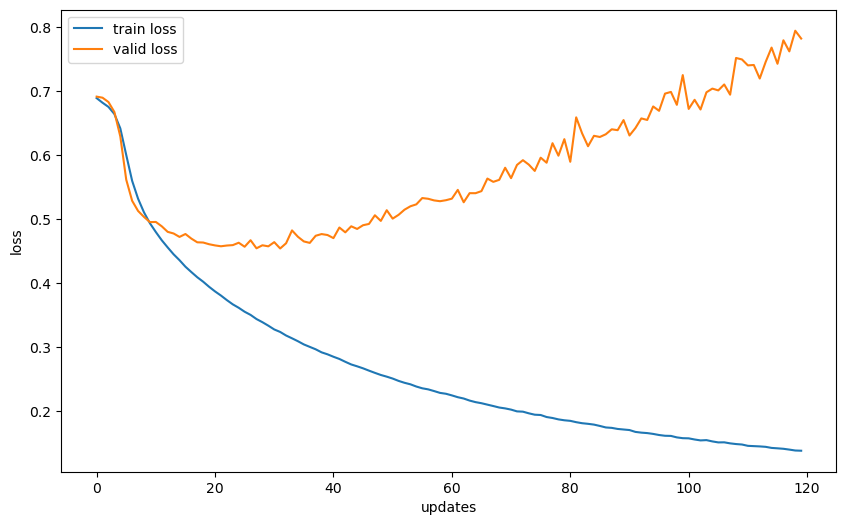

In [34]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

Text(0, 0.5, 'acc')

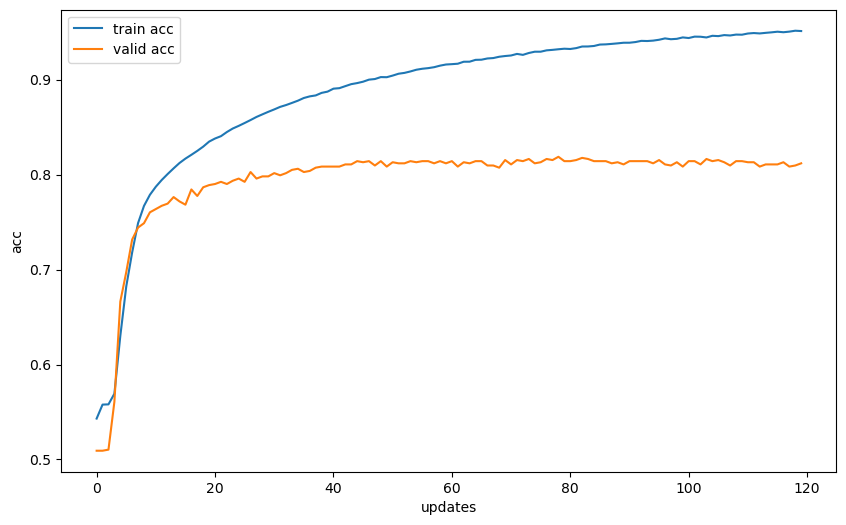

In [35]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_accs, label = 'train acc')
ax.plot(valid_accs, label = 'valid acc')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('acc')

In [36]:
model.load_state_dict(torch.load(save_path))

test_loss, test_acc = evaluate(model, test_loader, criterion, test_loader_length)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.325 | Test Acc: 87.25%


## load and test sentence

In [37]:
# test_datapipe = SST2(split="test")

In [5]:
from torch import nn
import torch
import json

In [1]:
import spacy

nlp = spacy.load("en_core_web_sm")

# use this instead of text_pipeline
def text2index(txt,vocab_dict):
    
    txt_to = nlp(txt)

    present = []
    for word in txt_to:
        
        if str(word) in vocab_dict:
            value = vocab_dict[str(word)]
        else:
            value = 0

        present.append(value)      

    return present


c:\Users\ASUS\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
json_dir ="models/vocab.json"
with open(json_dir, "r") as file:
    vocab_dict = json.load(file)


In [7]:
len(vocab_dict)

13891

In [8]:
text= 'Chaky wants his student to be number 1.'
print(text2index(text,vocab_dict))

[0, 944, 42, 3535, 10, 27, 940, 3009, 9]


In [78]:
len(vocab_dict)

13891

In [12]:
input_dim  = len(vocab_dict)
hid_dim    = 256
emb_dim    = 300       
output_dim = 2
save_path = "models/LSTM.pt"
#for biLSTM
num_layers = 2
bidirectional = True
dropout = 0.5
pad_ix=1

model_load = LSTM(input_dim, emb_dim, hid_dim, output_dim, num_layers, bidirectional, dropout)

model_load.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [13]:
def predict(text, text_length):
    with torch.no_grad():
        output = model_load(text, text_length).squeeze(1)
        predicted = torch.max(output.data, 1)[1]
        return predicted

In [19]:
# negative 
test_str = "this laptop is mulfuction"
text = torch.tensor(text2index(test_str,vocab_dict)).reshape(1, -1) 
text_length = torch.tensor([text.size(1)]).to(dtype=torch.int64)
predict(text, text_length).item()

0

In [20]:
type(predict(text, text_length).item())

int

In [82]:
#  positive
test_str = "this laptop is very good"
text = torch.tensor(text2index(test_str,vocab_dict)).reshape(1, -1) 
text_length = torch.tensor([text.size(1)]).to(dtype=torch.int64)
predict(text, text_length)

tensor([1])

In [83]:
# negative positive = negative
test_str = "this laptop is not so good"
text = torch.tensor(text2index(test_str,vocab_dict)).reshape(1, -1) 
text_length = torch.tensor([text.size(1)]).to(dtype=torch.int64)
predict(text, text_length)

tensor([0])

In [88]:
# negative negative = positive
test_str = "this laptop never make me disappointed"
text = torch.tensor(text2index(test_str,vocab_dict)).reshape(1, -1) 
text_length = torch.tensor([text.size(1)]).to(dtype=torch.int64)
predict(text, text_length)

# T^T fail

tensor([0])

## twitter scraper

In [85]:
import nest_asyncio # need this if run in ipynb
nest_asyncio.apply() #

import twint

c = twint.Config()

# c.Username = 'noneprivacy' 
c.Search = "bitcoin" # keyword
c.Limit = 10 
c.Store_object = True 
twint.run.Search(c)
tweets = twint.output.tweets_list

for tw in tweets:
    print(tw.tweet) # str

1625527896126128128 2023-02-14 23:10:25 +0700 <gameofbitcoin> Ladies and Gentlemen  May I present to you the European Central Bank  this is why #Bitcoin  https://t.co/k57i6QIsp6
1625527893718622217 2023-02-14 23:10:25 +0700 <CriptoBrasil> #Notícias Bitcoin (BTC) a US$ 500.000 é questão de tempo, dizem especialistas  https://t.co/VsOUrrYbOQ
1625527890954559495 2023-02-14 23:10:24 +0700 <CryptoCState> #Bitcoin Dips After Inflation Comes in Slightly Hot.  The Consumer Price Index (#CPI) for January rose 0.5% versus 0.1% a month earlier, and in line with economist forecasts.  https://t.co/VDmYHhQGcl
1625527888576663553 2023-02-14 23:10:24 +0700 <Bitclaser> 👉[Power's Cryptocurrency Rise and Exit Strategies] [DooriDoori 14/2/23] 🔔🔔🔔🔔🔔🔔🔔 👇👇👇👇👇👇👇  https://t.co/ReQnkEQmlv  @DooridooriCoin #dooridoori #doorinati  #bitcoin #crypto  https://t.co/UjePRLthiX
1625527871325487104 2023-02-14 23:10:20 +0700 <oligarchlite> Share market aur bitcoin mujhe samjh nahi aata  Mene toh Nari property banani hai 

## plot hist (just test)

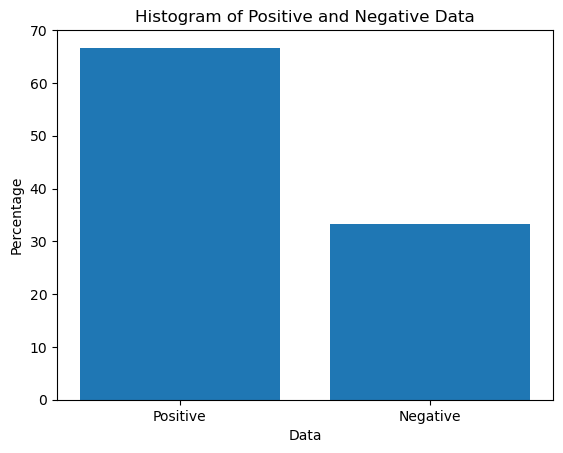

In [27]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

# Example data
positive_data = 10
negative_data = 5
total_data = positive_data + negative_data

# Calculate percentages
positive_percent = positive_data / total_data * 100
negative_percent = negative_data / total_data * 100

# Create a bar chart with two bars
plt.bar(['Positive', 'Negative'], [positive_percent, negative_percent])

# Add labels and title
plt.xlabel('Data')
plt.ylabel('Percentage')
plt.title('Histogram of Positive and Negative Data')

# Display the chart
plt.show()


In [30]:
import datetime
name = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

In [32]:
print(type(name))

<class 'str'>


## Conclusion   

It can't classify negative negative sentence but can classify the rest. 

To improve model maybe we can use hyperparameter tuning or change dataset or else .. don't know